In [1]:
# from aicsimageio import AICSImage
import numpy as np
import napari
import os
from src.utilities.functions import path_leaf
from glob2 import glob
import skimage.io as skio
import pandas as pd
from sklearn.decomposition import PCA
from joblib import dump, load
from sklearn.neural_network import MLPClassifier, MLPRegressor
import time
import vispy.color
import zarr
from scipy.spatial import Delaunay
from src.utilities.fin_class_def import FinData
from tqdm import tqdm
from scipy.spatial import distance_matrix
from src.utilities.surface_axes_functions import *

In [5]:
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"

fin_object_path = os.path.join(root, "point_cloud_data", "fin_objects", "")
fin_object_list = sorted(glob(fin_object_path + "*.pkl"))
# print(fin_object_list)

In [ ]:
# for i in range(curation_df.shape[0]):
#     well_num = curation_df.loc[i, "well_index"]
#     time_int = curation_df.loc[i, "time_index"]
#     point_prefix = experiment_date + f"_well{well_num:04}" + f"_time{time_int:04}"
#     object_path = os.path.join(fin_object_path, point_prefix + "_fin_object.pkl")
#     if not os.path.exists(object_path):
#         curation_df.loc[i, "fin_axis_approved"] = False
#         curation_df.loc[i, "body_axis_approved"] = False
#         curation_df.loc[i, "tissue_labels_approved"] = False
#     else:
#         fin_data = FinData(data_root=root, name=point_prefix, tissue_seg_model=seg_type_global)

In [35]:
file_ind = 11
seg_type = "tissue_only_best_model_tissue"
fp = fin_object_list[file_ind]
point_prefix = path_leaf(fp).replace("_fin_object.pkl", "")
print(point_prefix)

fin_data = FinData(data_root=root, name=point_prefix, tissue_seg_model=seg_type)

20240711_01_well0011_time0000
Loading saved pec fin data...


/tmp/ipykernel_3440553/2932103644.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



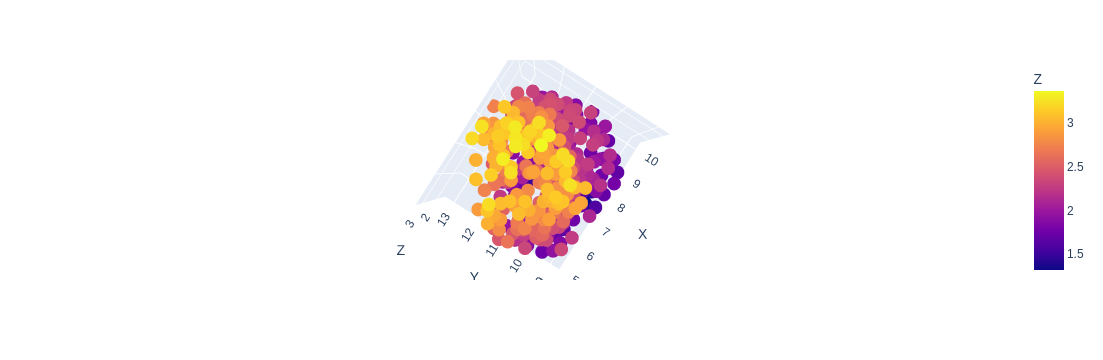

In [54]:
import plotly.express as px
import plotly.graph_objects as go

scale_factor = 25

fin_df = fin_data.full_point_data
fin_df = fin_df.loc[fin_df["fin_label_curr"]==1, :]

fin_df[["X", "Y", "Z"]] = fin_df[["X", "Y", "Z"]] / scale_factor

fig = px.scatter_3d(fin_df, x="X", y="Y", z="Z", color = "Z")

fig.update_layout(
             scene=dict(
                 aspectmode='data'
         ))

fig.show()

### Experiment with rotating fin to lie along 3 inferred fin axes

In [55]:
fin_points = fin_df.loc[:, ["X", "Y", "Z"]].to_numpy()
fin_axis_df = fin_data.axis_fin
fin_axes = fin_data.calculate_axis_array(fin_axis_df)
fin_points_pca = np.matmul(fin_points - np.mean(fin_points, axis=0), fin_axes.T)
fin_df.loc[:, ["XP", "YP", "ZP"]] = fin_points_pca

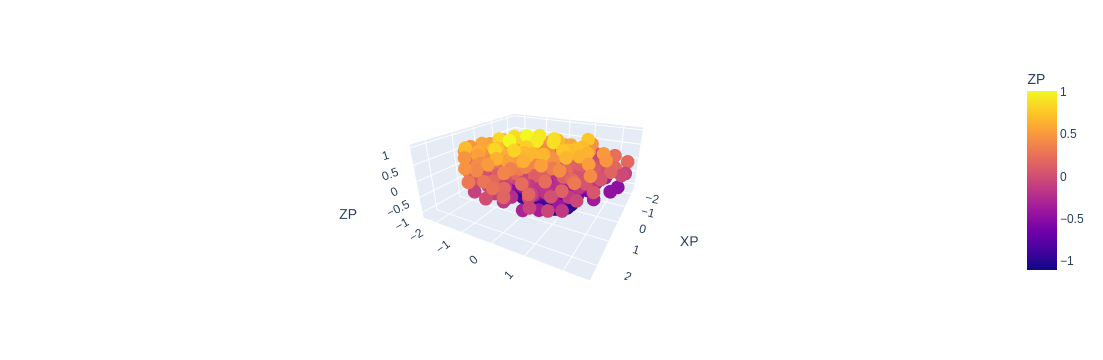

In [56]:
fig = px.scatter_3d(fin_df, x="XP", y="YP", z="ZP", color = "ZP")

fig.update_layout(
             scene=dict(
                 aspectmode='data'
         ))

fig.show()

### Estimate pointcloud density to enable upsampling

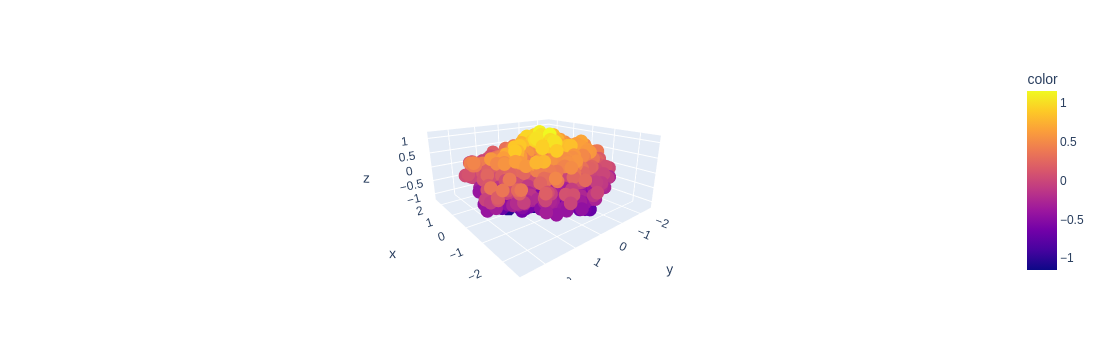

In [76]:
from sklearn.neighbors import KernelDensity

# fit density
X = fin_df[["XP", "YP", "ZP"]].to_numpy()
kde = KernelDensity(bandwidth=0.1, kernel="gaussian").fit(X)

# draw samples
fin_rs = kde.sample(n_samples=1024)


fig = px.scatter_3d(x=fin_rs[:, 0], y=fin_rs[:, 1], z=fin_rs[:, 2], color =fin_rs[:, 2])

fig.update_layout(
             scene=dict(
                 aspectmode='data'
         ))

fig.show()

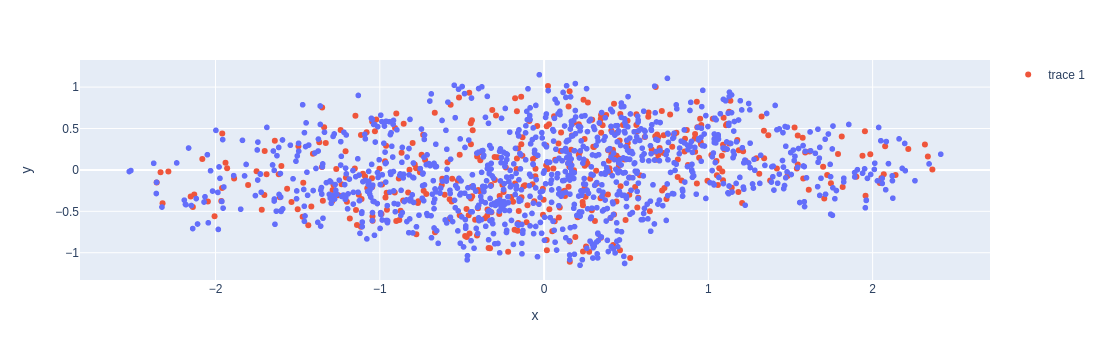

In [78]:
fig = px.scatter(x=fin_rs[:, 0], y=fin_rs[:, 2])
fig.add_trace(go.Scatter(x=X[:, 0], y=X[:, 2], mode="markers"))
fig.show()

In [52]:
kde.bandwidth

'scott'